In [1]:
!nvidia-smi

Sun Jun 20 18:32:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Yardımcı fonksiyonlar oluşturma

Makine öğrenimi deneyleriniz boyunca, muhtemelen tekrar tekrar kullanmak istediğiniz kod parçacıklarıyla karşılaşacaksınız.

Örneğin, bir modelin geçmiş nesnesini çizen bir çizim işlevi (aşağıdaki `plot_loss_curves()`'e bakın).

Bu işlevleri tekrar tekrar oluşturabilirsiniz.

```
from helper_functions import plot_loss_curves
 
...
 
plot_loss_curves(history)
```
Bunun neye benzediğini görelim.

In [2]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2021-06-20 18:32:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-20 18:32:50 (106 MB/s) - ‘helper_functions.py’ saved [10246/10246]



Harika, şimdi her seferinde sıfırdan yeniden yazmak zorunda kalmadan dizüstü bilgisayar boyunca kullanabileceğimiz bir dizi yardımcı işlevimiz var.

> 🔑 Not: Bu not defterini Google Colab'de çalıştırıyorsanız, zaman aşımına uğradığında Colab `helper_functions.py` dosyasını siler. Bu nedenle, yukarıda içe aktarılan işlevleri kullanmak için hücreyi yeniden çalıştırmanız gerekir.

## 10 Food Classes: Daha Az Veriyle Çalışmak

Bir önceki not defterinde, TensorFlow Hub ile aktarım öğrenimini kullanarak eğitim verilerinin yalnızca %10'u ile harika sonuçlar elde edebileceğimizi görmüştük.

Bu not defterinde, verilerin daha küçük alt kümeleriyle çalışmaya devam edeceğiz, ancak bu sefer `tf.keras.applications` modülündeki yerleşik önceden eğitilmiş modelleri ve ayrıca nasıl kullanabileceğimize bir göz atacağız. bunları kendi özel veri kümemize nasıl ince ayar yaparız.

Ayrıca, `tf.keras.preprocessing` modülünün bir parçası olan `image_dataset_from_directory()` adlı daha önce kullandığımıza benzer yeni ama benzer bir veri yükleyici işlevi kullanarak alıştırma yapacağız.

Son olarak, derin öğrenme modelleri oluşturmak için [Keras Function API](https://keras.io/guides/functional_api/)'sini kullanma alıştırması da yapacağız. İşlevsel API, modeller oluşturmanın [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing) API'sinden daha esnek bir yoludur.

Bunların her birini ilerledikçe daha ayrıntılı olarak inceleyeceğiz.

Bazı verileri indirerek başlayalım.

In [3]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2021-06-20 18:32:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   215MB/s    in 0.7s    

2021-06-20 18:32:53 (215 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



İndirdiğimiz veri seti, önceki not defterinde kullandığımız eğitim görüntülerinin %10'unu içeren 10 food classes veri setidir (Food 101'den).

> 🔑 Not: Bu veri kümesinin [nasıl oluşturulduğunu](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb) görüntü verisi değiştirme not defterinde görebilirsiniz.

In [4]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

Eğitim dizinlerinin her birinin 75 görüntü içerdiğini ve test dizinlerinin her birinin 250 görüntü içerdiğini görebiliriz.

Eğitim ve test dosya yollarımızı tanımlayalım.

In [5]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Şimdi elimizde bir miktar görüntü verisi var, onu TensorFlow uyumlu bir formata yüklemenin bir yoluna ihtiyacımız var.

Daha önce [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) sınıfını kullandık. Ve bu iyi çalışıyor ve hala çok yaygın olarak kullanılıyor olsa da, bu sefer `image_data_from_directory` işlevini kullanacağız.

`ImageDataGenerator`'ın `flow_from_directory` yöntemiyle hemen hemen aynı şekilde çalışır, yani resimlerinizin aşağıdaki dosya biçiminde olması gerekir:

```
# Example of file structure
10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```

`ImageDataGenerator` yerine `tf.keras.prepreprocessing.image_dataset_from_directory()` kullanmanın ana faydalarından biri, bir üreteç yerine bir `tf.data.Dataset` nesnesi oluşturmasıdır. Bunun ana avantajı, `tf.data.Dataset` API'sinin, daha büyük veri kümeleri için çok önemli olan ImageDataGenerator API'sinden çok daha verimli (daha hızlı) olmasıdır.

Eylemde görelim.

In [6]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Olağanüstü! Veri yükleyicilerimiz her veri kümesi için doğru sayıda görüntü bulmuş gibi görünüyor.

Şimdilik, image_dataset_from_directory() işlevinde ilgilendiğimiz ana parametreler şunlardır:

- **directory**<br>görüntüleri yüklediğimiz hedef dizinin dosya yolu.
- **image_size**<br> - yükleyeceğimiz görüntülerin hedef boyutu (yükseklik, genişlik).
- **batch_size**<br> - yükleyeceğimiz resimlerin toplu iş boyutu. Örneğin, toplu iş_boyutu 32 (varsayılan) ise, modele bir seferde 32 resim ve etiketten oluşan gruplar geçirilecektir.

[`tf.keras.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) belgelerinde gerekirse oynayabileceğimiz daha çok şey var.

Eğitim veri tipini kontrol edersek, onu verilerimizle ilgili şekiller içeren bir BatchDataset olarak görmeliyiz.

In [7]:
# Check the training data datatype
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

Yukarıdaki çıktıda:

- `(None, 224, 224, 3)`, None'un batchi, 224'ün yükseklik (ve genişlik) ve 3'ün renk kanalları (kırmızı, yeşil, mavi) olduğu görüntülerimizin tensör şeklini ifade eder.
- `(None, 10)`, None'un batch sayısı ve 10'un olası etiket sayısı olduğu (10 farklı gıda sınıfı) etiketlerin tensör şeklini belirtir.
- Hem görüntü tensörleri hem de etiketler tf.float32 veri tipindedir.

Batch_size, yalnızca model eğitimi sırasında kullanıldığından None değerine eşittir. None'un  image_dataset_from_directory()'deki batch_size parametresiyle doldurulmayı bekleyen bir yer tutucu olarak düşünebilirsiniz.

tf.data.Dataset API'sini kullanmanın bir başka yararı da onunla birlikte gelen ilişkili yöntemlerdir.

Örneğin çalıştığımız sınıfların adını bulmak istiyorsak class_names özniteliğini kullanabiliriz.

In [8]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Veya örnek bir veri yığını görmek istersek, take() yöntemini kullanabiliriz.

In [9]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.94285717e+01 2.39285717e+01 4.97142868e+01]
   [3.47244911e+01 1.77346935e+01 4.47346954e+01]
   [6.43775482e+01 2.42857151e+01 5.81938782e+01]
   ...
   [4.17857361e+01 1.15714722e+01 1.42142639e+01]
   [4.40102043e+01 1.40102062e+01 1.40102062e+01]
   [4.54490089e+01 1.54490099e+01 1.34490099e+01]]

  [[9.43877506e+00 2.49387760e+01 4.42959213e+01]
   [1.04183674e+01 1.78265305e+01 3.75714264e+01]
   [2.64183693e+01 1.76734695e+01 4.19387741e+01]
   ...
   [4.22143059e+01 1.20000439e+01 1.46428356e+01]
   [4.40714417e+01 1.40714417e+01 1.40714417e+01]
   [4.60000000e+01 1.60000000e+01 1.40000000e+01]]

  [[6.01020336e+00 2.86020412e+01 4.86428566e+01]
   [1.31632650e+00 2.53979588e+01 4.23775482e+01]
   [3.16326666e+00 2.15714283e+01 3.81224480e+01]
   ...
   [4.22244949e+01 1.14489918e+01 1.59285498e+01]
   [4.40204124e+01 1.40204115e+01 1.54489832e+01]
   [4.52857132e+01 1.52857141e+01 1.47142859e+01]]

  ...

  [[1.19000000e+02 1.36857117e+02 1.64571411e+02]
   [1

Görüntü dizilerinin piksel değerlerinin tensörleri olarak nasıl ortaya çıktığına dikkat edin, burada etiketler tek sıcak kodlamalar olarak ortaya çıkar (örneğin hamburger için [0. 0. 0. 0. 1. 0. 0. 0. 0.]) .

## Model 0: Keras İşlevsel API'sini kullanarak bir aktarım öğrenme modeli oluşturma

Pekala, verilerimiz tensörlü, hadi bir model oluşturalım.

Bunu yapmak için [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) modülünü kullanacağız, çünkü bu modül zaten eğitilmiş (ImageNet'te) bir dizi bilgisayarlı görü modelinin yanı sıra modelimizi oluşturmak için Keras İşlevsel API'sini içerir.

Aşağıdaki adımlardan geçeceğiz:

1. tf.keras.applications'dan EfficientNetB0 gibi bir hedef model seçerek, include_top parametresini False olarak ayarlayarak önceden eğitilmiş bir temel model nesnesini örnekleyin (bunu yapıyoruz çünkü çıktı katmanları olan kendi topumuzu oluşturacağız). modeli).
2. Önceden eğitilmiş modeldeki tüm ağırlıkları dondurmak için temel modelin eğitilebilir niteliğini False olarak ayarlayın.
3. Modelimiz için bir girdi katmanı tanımlayın, örneğin modelimiz hangi veri şeklini beklemelidir?
4. [Opsiyonel] Gerekiyorsa, girdileri modelimize normalleştirin. ResNetV250 gibi bazı bilgisayarlı görme modelleri, girişlerinin 0 ve 1 arasında olmasını gerektirir.
> 🤔 Not: Yazıldığı gibi, tf.keras.applications modülündeki EfficientNet modelleri, diğer birçok modelde olduğu gibi, girişte görüntülerin normalleştirilmesini (0 ile 1 arasındaki piksel değerleri) gerektirmez. TensorFlow GitHub'a bununla ilgili bir sorun gönderdim ve bunu onayladılar.

5. Girdileri temel modele iletin.
6. Temel modelin çıktılarını, çıktı etkinleştirme katmanıyla uyumlu bir şekle toplayın (temel model çıktı tensörlerini etiket tensörleriyle aynı şekle çevirin). Bu, tf.keras.layers.GlobalAveragePooling2D() veya tf.keras.layers.GlobalMaxPooling2D() kullanılarak yapılabilir, ancak ilki pratikte daha yaygındır.
7. Uygun aktivasyon fonksiyonu ve nöron sayısı ile tf.keras.layers.Dense() kullanarak bir çıktı aktivasyon katmanı oluşturun.
8. tf.keras.Model() kullanarak girdi ve çıktı katmanını bir modelde birleştirin.
9. Uygun kayıp fonksiyonunu kullanarak modeli derleyin ve optimize ediciyi seçin.
10. Modeli istenen sayıda batch ve gerekli callback için uydurun (bizim durumumuzda, TensorBoard callback'i ile başlayacağız).
Vay... kulağa çok gibi geliyor. Kendimizi aşmadan önce, pratikte görelim.

In [10]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

16711680/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20210620-183303
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 42s 309ms/step - loss: 1.8379 - accuracy: 0.4213 - val_loss: 1.2908 - val_accuracy: 0.7319
Epoch 2/5
24/24 [==============================] - 5s 193ms/step - loss: 1.1175 - accuracy: 0.7493 - val_loss: 0.9067 - val_accuracy: 0.7961
Epoch 3/5
24/24 [==============================] - 5s 193ms/step - loss: 0.8154 - accuracy: 0.8173 - val_loss: 0.7409 - val_accuracy: 0.8224
Epoch 4/5
24/24 [==============================] - 5s 193ms/step - loss: 0.6689 - accuracy: 0.8333 - val_loss: 0.6414 - val_accuracy: 0.8438
Epoch 5/5
24/24 [==============================] - 5s 204ms/step - loss: 0.5805 - accuracy: 0.8600 - val_loss: 0.5819 - val_accuracy: 0.8454


Güzel! Yaklaşık bir dakikalık eğitimden sonra modelimiz hem eğitim (%87+ doğruluk) hem de test setlerinde (~%83 doğruluk) inanılmaz derecede iyi performans gösteriyor.

Bu inanılmaz. Hepsi transfer öğrenmenin gücü sayesinde.

TensorFlow Hub modellerinde yaptığımıza benzer şekilde, burada kullandığımız transfer öğrenimi türünün özellik çıkarma transfer öğrenimi olarak adlandırıldığını not etmek önemlidir.

Başka bir deyişle, özel verilerimizi önceden eğitilmiş bir modele (EfficientNetB0) ilettik ve "hangi kalıpları görüyorsunuz?" diye sorduk. ve ardından çıktıların istediğimiz sınıf sayısına göre uyarlandığından emin olmak için kendi çıktı katmanımızı en üste koyun.

Modelimizi oluşturmak için Sıralı API yerine Keras İşlevsel API'sini de kullandık. Şimdilik, bu ana yöntemin faydaları net görünmüyor, ancak daha karmaşık modeller oluşturmaya başladığınızda, muhtemelen İşlevsel API'yi kullanmak isteyeceksiniz. Bu nedenle, bu model oluşturma yöntemine maruz kalmak önemlidir.

> 📖 Kaynak: Sıralı API'ye karşı İşlevsel API'nin faydalarını ve kullanım örneklerini görmek için TensorFlow [İşlevsel API belgelerine](https://www.tensorflow.org/guide/keras/functional) bakın.

Modelimizdeki katmanları inceleyelim, temelden başlayacağız.

In [11]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

Vay canına, bu çok fazla katman... bunların hepsini elle kodlamak oldukça uzun zaman alacaktı, yine de transfer öğrenmenin gücü sayesinde bunlardan faydalanabiliriz.

Temel modelin bir özetine ne dersiniz?

In [12]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

Genel modelimiz beş katmana sahiptir, ancak gerçekte bu katmanlardan biri `(efficientnetb0)` 236 katmana sahiptir.

Çıktı şeklinin giriş katmanı (resimlerimizin şekli) için (None, 224, 224, 3) olarak nasıl başladığını, ancak çıktı katmanı (etiketlerimizin şekli) tarafından (None, 10) olarak nasıl dönüştürüldüğünü görebilirsiniz. ), burada None, batch boyutu için yer tutucudur.

Modeldeki eğitilebilir parametreler yalnızca çıktı katmanındaki parametrelerdir.

Modelimizin eğitim eğrileri nasıl görünüyor?

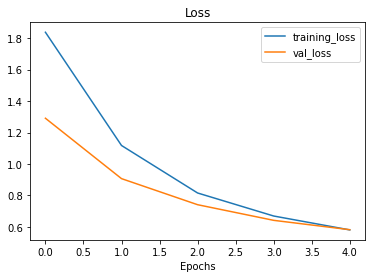

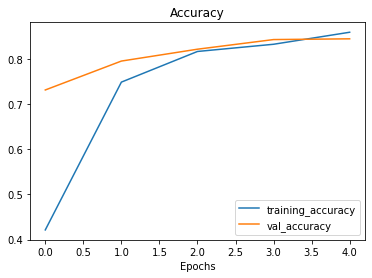

In [13]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Eğitilmiş bir modelden bir özellik vektörü alma

> 🤔 Soru: tf.keras.layers.GlobalAveragePooling2D() katmanına ne olur? Daha önce görmedim.

[`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) katmanı, iç eksenlerdeki değerlerin ortalamasını alarak 4B tensörü 2B tensöre dönüştürür.

Önceki cümle biraz ağız dolusu, o yüzden bir örnek görelim.


In [14]:
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


`tf.keras.layers.GlobalAveragePooling2D()` katmanının giriş tensörünü şekilden (1, 4, 4, 3) (1, 3)'e yoğunlaştırdığını görebilirsiniz. Bunu, ortadaki iki eksen boyunca input_tensor'un ortalamasını alarak yaptı.

Bu işlemi tf.reduce_mean() işlemini kullanarak ve uygun eksenleri belirleyerek çoğaltabiliriz.

In [15]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Bunu yapmak, yalnızca temel modelin çıktısını, çıktı katmanımızın (tf.keras.layers.Dense()) girdi şekli gereksinimi ile uyumlu hale getirmekle kalmaz, aynı zamanda temel model tarafından bulunan bilgiyi daha düşük boyutlu bir özellik vektöründe yoğunlaştırır.

> 🔑 Not: Özellik çıkarma transfer öğreniminin nasıl olduğu olarak adlandırılmasının nedenlerinden biri, önceden eğitilmiş bir modelin bir özellik vektörü vermesidir (bizim durumumuzda bu, [tf.keras.Layer.GlobalAveragePooling2D()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D)  katmanı çıktısıdır.), daha sonra kalıpları çıkarmak için kullanılabilir.

> 🛠 Alıştırma: Yukarıdaki hücreyle aynısını yapın, ancak [tf.keras.layers.GlobalMaxPool2D()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D) için.

## Bir dizi transfer learning deneyi yürütme

Eğitim verilerinin %10'unda transfer öğreniminin inanılmaz sonuçlarını gördük, peki ya eğitim verilerinin %1'i?

Kendi yaptığımız orijinal CNN modellerinden 100 kat daha az veri kullanarak ne tür sonuçlar elde edebileceğimizi düşünüyorsunuz?

Aşağıdaki modelleme deneylerini çalıştırırken neden bu soruyu yanıtlamıyoruz:

- `model_1` : Veri büyütme ile eğitim verilerinin %1'inde özellik çıkarma aktarımı öğrenimini kullanın.
- `model_2`: Veri büyütme ile eğitim verilerinin %10'unda özellik çıkarma aktarımı öğrenimini kullanın.
- `model_3`: Veri artırma ile eğitim verilerinin %10'unda transfer öğrenimini ince ayar kullanarak kullanın.
- `model_4`: Veri büyütme ile eğitim verilerinin %100'ünde transfer öğrenimi ince ayarını kullanın.

Tüm deneyler, eğitim verilerinin farklı versiyonları üzerinde yürütülecek olsa da, hepsi aynı test veri setinde değerlendirilecek ve bu, her deneyin sonuçlarının mümkün olduğunca karşılaştırılabilir olmasını sağlar.

Tüm deneyler tf.keras.applications modülü içerisinde EfficientNetB0 modeli kullanılarak yapılacaktır.

Deneylerimizi takip ettiğimizden emin olmak için tüm model eğitim günlüklerini günlüğe kaydetmek için `create_tensorboard_callback()` işlevimizi kullanacağız.

Her modeli Keras Functional API kullanarak oluşturacağız ve daha önce yaptığımız gibi `ImageDataGenerator` sınıfında veri büyütmeyi uygulamak yerine, onu `tf.keras.layers.experimental.preprocessing` modülünü kullanarak doğrudan modelin içine inşa edeceğiz.

Veri büyütmeli eğitim verilerinin %1'inde özellik çıkarma aktarımı öğrenimini kullanarak deney 1 için verileri indirerek başlayalım.

In [16]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2021-06-20 18:34:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 173.194.203.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   223MB/s    in 0.6s    

2021-06-20 18:34:07 (223 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [17]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

Pekala, her sınıftan yalnızca yedi resmimiz var gibi görünüyor, bu modelimiz için biraz zor olmalı.

> 🔑 Not: Veri alt kümesinin %10'unda olduğu gibi, görüntülerin %1'i orijinal tam eğitim veri kümesinden rastgele seçilmiştir. Test görüntüleri daha önce kullanılmış olanlarla aynıdır. Bu verilerin nasıl önceden işlendiğini görmek istiyorsanız, [Food Vision Görüntü Ön İşleme defterine](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb) bakın.

Resimlerimizi tf.data.Dataset nesneleri olarak yükleme zamanı, bunu yapmak için image_dataset_from_directory() yöntemini kullanacağız.

In [18]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Doğrudan modele veri büyütme ekleme

Daha önce eğitim görüntülerimizi güçlendirmek için ImageDataGenerator sınıfının farklı parametrelerini kullandık, bu sefer doğrudan modelin içine veri büyütmeyi inşa edeceğiz.

Nasıl?

tf.keras.layers.experimental.preprocessing modülünü kullanma ve özel bir veri büyütme katmanı oluşturma.

Bu, TensorFlow 2.2+ sürümüne eklenen nispeten yeni bir özelliktir ancak çok güçlüdür. Modele bir veri büyütme katmanı eklemek aşağıdaki avantajlara sahiptir:

- Görüntülerin ön işlemesi (artırılması) CPU yerine GPU'da gerçekleşir (çok daha hızlı).
  - Görüntüler en iyi GPU'da ön işlenirken, metin ve yapılandırılmış veriler CPU'da önişlenmeye daha uygundur.
- Görüntü verisi büyütme yalnızca eğitim sırasında gerçekleşir, bu nedenle yine de tüm modelimizi dışa aktarabilir ve başka bir yerde kullanabiliriz. Ve başka biri bizimle aynı modeli eğitmek isterse, aynı türde veri büyütme de dahil olmak üzere, yapabilirdi.

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-data-augmentation-inside-a-model.png" />

*Bir model (EfficientNetB0) içinde ilk katman olarak veri büyütmeyi kullanma örneği.*

> 🤔 Not: Yazma sırasında, veri büyütme için kullandığımız ön işleme katmanları, TensorFlow kitaplığında deneysel durumda. Bu, katmanların kararlı olarak kabul edilmesi gerekmesine rağmen, TensorFlow'un gelecekteki bir sürümünde kodun biraz değişebileceği anlamına gelir. Mevcut diğer ön işleme katmanları ve farklı veri artırma yöntemleri hakkında daha fazla bilgi için [Keras ön işleme katmanları kılavuzuna](https://keras.io/guides/preprocessing_layers/) ve [TensorFlow veri artırma kılavuzuna](https://www.tensorflow.org/tutorials/images/data_augmentation) bakın.

Veri büyütmeyi doğrudan modelimizde kullanmak için, yalnızca veri ön işleme katmanlarından oluşan bir Keras Sıralı modeli oluşturacağız, daha sonra bu Sıralı modeli başka bir İşlevsel model içinde kullanabiliriz.

Bu kafa karıştırıcı geliyorsa, kodda oluşturduğumuzda mantıklı olacaktır.

Kullanacağımız veri büyütme dönüşümleri şunlardır:

- RandomFlip - görüntüyü yatay veya dikey eksende döndürür.
- RandomRotation - görüntüyü belirli bir miktarda rastgele döndürür.
- RandomZoom - bir görüntüyü belirtilen miktarda rastgele yakınlaştırır.
- RandomHeight - görüntü yüksekliğini belirli bir miktarda rastgele kaydırır.
- RandomWidth - görüntü genişliğini belirli bir miktarda rastgele kaydırır.
- Rescaling - görüntü piksel değerlerini 0 ile 1 arasında olacak şekilde normalleştirir, bazı görüntü modelleri için gerekli olduğundan ancak EfficientNetB0'ın tf.keras.applications uygulamasını kullandığımızdan bu gerekli değildir.

Daha fazla seçenek var ama şimdilik bunlar yeterli.

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

Ve bu kadar! Veri büyütme Sıralı modelimiz kullanıma hazır. Birazdan göreceğiniz gibi, bu "modeli" daha sonra transfer öğrenme modelimize bir katman olarak yerleştirebileceğiz.

Ama bunu yapmadan önce, içinden rastgele görüntüler geçirerek test edelim.

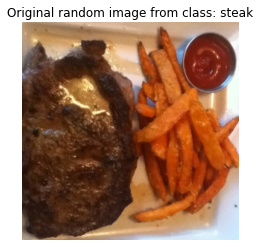

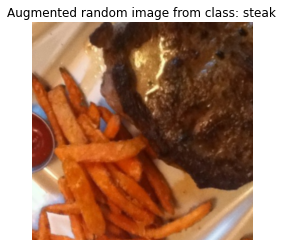

In [20]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

Yukarıdaki hücreyi birkaç kez çalıştırın ve farklı görüntü sınıflarında farklı rastgele büyütmeleri görebilirsiniz. Gelecek transfer öğrenme modelimizde veri büyütme modelini bir katman olarak ekleyeceğimiz için, içinden geçen eğitim görüntülerinin her birine bu tür rastgele büyütmeler uygulayacaktır.

Bunu yapmak, eğitim veri setimizi biraz daha çeşitli hale getirecektir. Gerçek hayatta bir yemek fotoğrafı çekiyormuşsunuz gibi düşünebilirsiniz, görüntülerin hepsi mükemmel olmayacak, bazıları garip şekillerde yönlendirilecek. Bunlar, modelimizin işlemesini istediğimiz türden görüntüler.

Modelden bahsetmişken, İşlevsel API ile bir tane oluşturalım. Bir fark dışında önceki adımların aynısını uygulayacağız, girdi katmanından hemen sonra veri büyütme Sıralı modelimizi katman olarak ekleyeceğiz.

### Model 1: Veri büyütme ile verilerin %1'inde özellik çıkarma aktarımı öğrenimi

In [21]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210620-183411


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
3/3 [==============================] - 11s 3s/step - loss: 2.3859 - accuracy: 0.0571 - val_loss: 2.2446 - val_accuracy: 0.1382
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1691 - accuracy: 0.1571 - val_loss: 2.1263 - val_accuracy: 0.2237
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 2.0096 - accuracy: 0.3429 - val_loss: 2.0316 - val_accuracy: 0.3273
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8468 - accuracy: 0.4000 - val_loss: 1.9335 - val_accuracy: 0.3717
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.7225 - accuracy: 0.5143 - val_loss: 1.8533 - val_accuracy: 0.4227


Vaov! Ne kadar cool? Sınıf başına yalnızca 7 eğitim görüntüsü kullanarak, transfer öğrenmeyi kullanarak modelimiz doğrulama setinde ~%40 doğruluk elde edebildi. Orijinal Food-101 belgesi tüm verilerle, yani sınıf başına 750 eğitim görüntüsü ile %50,67 doğruluk elde ettiğinden bu sonuç oldukça şaşırtıcıdır (not: bu ölçüm 10 değil 101 sınıftaydı, yakında 101 sınıfa ulaşacağız) .

Modelimizin bir özetini kontrol edersek, girdi katmanından hemen sonra veri büyütme katmanını görmeliyiz.

In [22]:
# Check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


İşte burada. Artık doğrudan modelimizin içine yerleştirilmiş veri büyütmeye sahibiz. Bu, onu kaydedip başka bir yere yeniden yüklesek, veri artırma katmanlarının da onunla birlikte geleceği anlamına gelir.

Hatırlanması gereken önemli şey, veri artırmanın yalnızca eğitim sırasında çalıştığıdır. Dolayısıyla, modelimizi çıkarım için değerlendirecek veya kullanacak olursak (bir görüntünün sınıfını tahmin ederek) veri büyütme katmanları otomatik olarak kapatılacaktır.

Bunu çalışırken görmek için modelimizi test verileri üzerinden değerlendirelim.

In [23]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 9s 109ms/step - loss: 1.8523 - accuracy: 0.4140


[1.8522588014602661, 0.414000004529953]

Buradaki sonuçlar, eğitim sırasında modelimizin günlük çıktılarından biraz daha iyi/daha kötü olabilir, çünkü eğitim sırasında modelimizi validation_steps=int(0.25 * len(test_data)) satırını kullanarak test verilerinin yalnızca %25'i üzerinde değerlendiririz. Bunu yapmak epoch'u  hızlandırır ama yine de bize modelimizin nasıl gittiğine dair yeterince fikir verir.

Tutarlı kalalım ve modelimizin kayıp eğrilerini kontrol edelim.

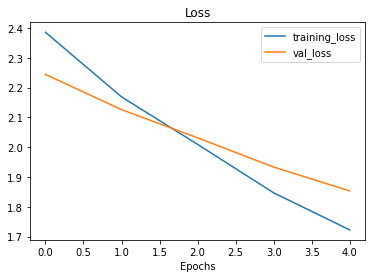

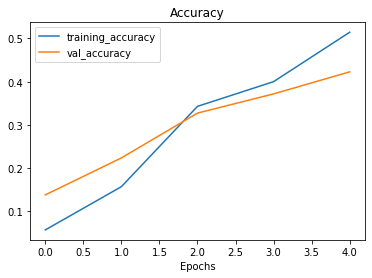

In [24]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

Daha fazla dönem için eğitime devam edersek, her iki veri kümesindeki metrikler de iyileşecek gibi görünüyor. Ama şimdilik bunu bırakalım, yapacak daha çok deneyimiz var!

### Model 2: %10 veri ve veri büyütme ile özellik çıkarma aktarımı öğrenimi

Pekala, veri artırma ile eğitim verilerinin %1'ini test ettik, veri artırma ile verilerin %10'unu denemeye ne dersiniz?

Fakat bekle...

> 🤔 Soru: Hangi deneyleri çalıştıracağınızı nereden biliyorsunuz?

Harika bir soru.

Buradaki gerçek şu ki, çoğu zaman yapmayacaksın. Makine öğrenimi hala çok deneysel bir uygulamadır. Sadece birkaç şeyi denedikten sonra, ne denemeniz gerektiğine dair bir sezgi geliştirmeye başlayacaksınız.

Benim tavsiyem, merakınızı mümkün olduğunca inatla takip etmenizdir. Bir şey denemek istediğinizi düşünüyorsanız, kodunu yazın ve çalıştırın. Nasıl gittiğini gör. Olabilecek en kötü şey, neyin işe yaramadığını, en değerli bilgi türünü bulmanızdır.

Pratik açıdan, daha önce bahsettiğimiz gibi, ilk deneyleriniz arasındaki süreyi mümkün olduğunca azaltmak isteyeceksiniz. Başka bir deyişle, umut verici bir şey bulmadan önce daha az veri ve daha az eğitim yinelemesi kullanarak çok sayıda daha küçük deney yapın ve ardından ölçeği büyütün.

Ölçek temasında, %1 eğitim verisi artırma denememizi %10 eğitim verisi artırımına kadar ölçeklendirelim. Bu cümle pek mantıklı değil ama ne demek istediğimi anladınız.

Önceki modelle tamamen aynı adımları uygulayacağız, tek fark eğitim verilerinin %1 yerine %10'unu kullanmaktır.

In [25]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [26]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Harika! Çalışmak için 10 kat daha fazla görselimiz var, sınıf başına 7 yerine sınıf başına 75.

Veri büyütmenin yerleşik olduğu bir model oluşturalım. Daha önce oluşturduğumuz veri büyütme Sıralı modelini yeniden kullanabiliriz, ancak pratik yapmak için yeniden oluşturacağız.

In [27]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#### ModelCheckpoint geri arama oluşturma

Modelimiz derlenmiş ve fit olmaya hazır, peki neden hala çalıştırmadık?

Pekala, bu deney için yeni bir callback'i, ModelCheckpoint callback'ini tanıtacağız.

[ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback'i, modelinizi bir bütün olarak [SavedModel](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) biçiminde veya ağırlıkları (kalıplar) yalnızca eğitilirken belirli bir dizine kaydetme yeteneği verir.

Modelinizin uzun süre eğitim göreceğini düşünüyorsanız ve eğitim sırasında yedeklerini almak istiyorsanız bu yararlıdır. Bu aynı zamanda, modelinizin daha uzun süre eğitilmesinden yararlanabileceğini düşünüyorsanız, belirli bir kontrol noktasından yeniden yükleyebilir ve oradan eğitime devam edebilirsiniz.

Örneğin, 5 dönem için bir özellik çıkarma transferi öğrenme modeline uyduğunuzu ve eğitim eğrilerini kontrol ettiğinizi ve hala iyileştiğini gördüğünüzü ve başka bir 5 dönem için ince ayarın yardımcı olup olmayacağını görmek istediğinizi varsayalım, kontrol noktasını yükleyebilir, dondurabilirsiniz. temel model katmanlarının bir kısmını (veya tamamını) ve ardından eğitime devam edin.

Aslında, yapacağımız şey tam olarak bu.

Ama önce bir ModelCheckpoint callbackini oluşturalım. Bunu yapmak için, kaydetmek istediğimiz bir dizini belirtmeliyiz.

In [28]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

> 🤔 Soru: Tüm modeli kaydetme (SavedModel biçimi) ile yalnızca ağırlıkları kaydetme arasındaki fark nedir?

SavedModel formatı, bir modelin mimarisini, ağırlıklarını ve eğitim yapılandırmasını tek bir klasöre kaydeder. Modelinizi tam olarak başka bir yerde olduğu gibi yeniden yüklemenizi çok kolaylaştırır. Ancak, tüm bu ayrıntıları başkalarıyla paylaşmak istemiyorsanız, yalnızca ağırlıkları kaydedip paylaşmak isteyebilirsiniz (bunlar yalnızca insan tarafından yorumlanamayan sayıların büyük tensörleri olacaktır). Disk alanı bir sorunsa, yalnızca ağırlıkları kaydetmek daha hızlıdır ve tüm modeli kaydetmekten daha az yer kaplar.

Modele uyma zamanı.

Daha sonra ince ayar yapacağımız için, bir initial_epochs değişkeni oluşturacağız ve daha sonra kullanmak üzere 5'e ayarlayacağız.

Ayrıca checkpoint_callback'imizi geri arama listemize ekleyeceğiz.

In [29]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210620-183451
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 19s 599ms/step - loss: 1.9855 - accuracy: 0.3467 - val_loss: 1.4638 - val_accuracy: 0.6447

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 10s 425ms/step - loss: 1.3547 - accuracy: 0.6467 - val_loss: 1.0201 - val_accuracy: 0.7812

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 10s 408ms/step - loss: 1.0487 - accuracy: 0.7360 - val_loss: 0.8205 - val_accuracy: 0.8141

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 10s 390ms/step - loss: 0.8938 - accuracy: 0.7640 - val_loss: 0.7274 - val_accuracy: 0.8043

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 9s 348ms/step - loss: 0.8010 - accuracy: 0.7853 - val_l

Şuna bakar mısın! Görünüşe göre ModelCheckpoint geri aramamız işe yaradı ve modelimiz her epoch'ta çok fazla ek yük olmadan ağırlıklarını kurtardı (tüm modeli kaydetmek yalnızca ağırlıklardan daha uzun sürüyor).

Modelimizi değerlendirelim ve kayıp eğrilerini kontrol edelim.

In [30]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 9s 105ms/step - loss: 0.6856 - accuracy: 0.8156


[0.6855890154838562, 0.8155999779701233]

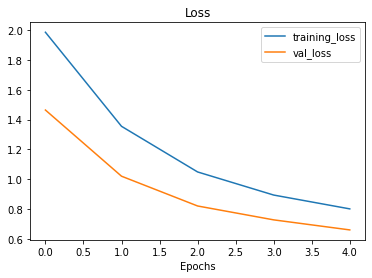

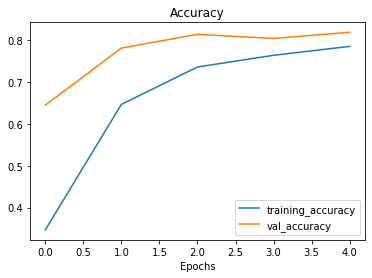

In [31]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

Bunlara bakıldığında, modelimizin %10 veri ve veri büyütme ile performansı, veri artırma olmadan %10 veri içeren model kadar iyi değil (yukarıdaki model_0 sonuçlarına bakın), ancak eğriler doğru yönde ilerliyor, yani daha uzun süre antrenman yapmaya karar verirsek, metrikleri muhtemelen iyileşir.

Modelimizin ağırlıklarını kontrol ettiğimiz için (bu bir kelime mi?) Modelimizin ağırlıklarını tekrar yüklemenin nasıl bir şey olduğunu görebiliriz. Test verileri üzerinde değerlendirerek doğru şekilde kaydedilip kaydedilmediğini test edebileceğiz.

Kaydedilmiş model ağırlıklarını yüklemek için [load_weights()](https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_options) yöntemini kullanabilirsiniz ve bu yöntemi, kaydedilmiş ağırlıklarınızın depolandığı yola iletebilirsiniz.

In [32]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.6856 - accuracy: 0.8156


Şimdi daha önce eğitilmiş modelimiz ile yüklenen modelin sonuçlarını karşılaştıralım. Bu sonuçlar tam olarak aynı olmasa da çok yakın olmalıdır. Küçük farklılıkların nedeni, hesaplanan sayıların kesinlik düzeyinden kaynaklanmaktadır.

In [33]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

False

In [34]:
import numpy as np

# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.78813934e-07  0.00000000e+00]


#### Model 3: Verilerin %10'unda mevcut bir modelde ince ayar yapma (Fine Tuning)

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-fine-tuning-an-efficientnet-model.png" />

Şimdiye kadar kaydedilen modelimiz, eğitim verilerinin %10'u ve veri artırma üzerinde 5 epoch boyunca özellik çıkarma aktarımı öğrenimi kullanılarak eğitildi.

Bu, temel modeldeki (EfficientNetB0) tüm katmanların eğitim sırasında dondurulduğu anlamına gelir.

Bir sonraki denememiz için transfer öğreniminin ince ayarına geçeceğiz. Bu, bazı katmanlarını (üste en yakın olanları) çözmemiz ve modeli birkaç dönem daha çalıştırmamız dışında aynı temel modeli kullanacağımız anlamına gelir.

İnce ayar fikri, önceden eğitilmiş modeli kendi verilerimize göre daha fazla özelleştirmeye başlamaktır.

> 🔑 Not: İnce ayar genellikle en iyi, birkaç epoch için ve büyük miktarda veri içeren bir özellik çıkarma modelini eğittikten sonra çalışır.

Yüklenen modelimizin performansını doğruladık, katmanlarına bir göz atalım.

In [35]:
# Layers in loaded model
model_2.layers

In [36]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


İyi görünüyor. Bir girdi katmanına, bir Sıralı katmana (veri artırma modeli), bir İşlevsel katmana (EfficientNetB0), bir havuz katmanına ve bir Yoğun katmana (çıkış katmanı) sahibiz.

Bir özete ne dersiniz?

In [37]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Pekala, `efficientnetb0` katmanındaki tüm katmanlar donmuş gibi görünüyor. Bunu trainable_variables niteliğini kullanarak onaylayabiliriz.

In [38]:
# How many layers are trainable in our base model?
print(len(model_2.layers[2].trainable_variables)) # layer at index 2 is the EfficientNetB0 layer (the base model)

0


Bu, temel modelimiz ile aynıdır.

In [39]:
print(len(base_model.trainable_variables))

0


Eğitilebilir olup olmadıklarını görmek için katman katman bile kontrol edebiliriz.

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

Güzel! Görünüşe göre son 10 dışındaki tüm katmanlar donmuş ve eğitilemez. Bu, çıktı katmanıyla birlikte yalnızca temel modelin son 10 katmanının ağırlıklarının eğitim sırasında güncelleneceği anlamına gelir.

> 🤔 Soru: Modeli neden yeniden derledik?

Modellerinizde her değişiklik yaptığınızda, onları yeniden derlemeniz gerekir.

Bizim durumumuzda, öncekiyle tamamen aynı kayıp, optimize edici ve metrikleri kullanıyoruz, ancak bu sefer optimize edicimizin öğrenme oranı öncekinden 10 kat daha küçük olacak (Adam'ın varsayılan değeri olan 0,001 yerine 0,0001).

Bunu, modelin önceden eğitilmiş modeldeki mevcut ağırlıkların üzerine çok hızlı yazmaya çalışmaması için yapıyoruz. Başka bir deyişle, öğrenmenin daha kademeli olmasını istiyoruz.

> 🔑 Not: İnce ayar sırasında öğrenme oranını ayarlamak için belirlenmiş bir standart yoktur, ancak 2,6x-10x+'lik azalmalar uygulamada iyi sonuç veriyor gibi görünmektedir.

Şimdi kaç tane eğitilebilir değişkenimiz var?

In [43]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210620-183715
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 10s 389ms/step - loss: 0.7351 - accuracy: 0.8053 - val_loss: 0.6060 - val_accuracy: 0.8355
Epoch 6/10
24/24 [==============================] - 9s 376ms/step - loss: 0.6665 - accuracy: 0.8373 - val_loss: 0.5740 - val_accuracy: 0.8438
Epoch 7/10
24/24 [==============================] - 9s 360ms/step - loss: 0.6202 - accuracy: 0.8467 - val_loss: 0.5519 - val_accuracy: 0.8454
Epoch 8/10
24/24 [==============================] - 10s 388ms/step - loss: 0.5829 - accuracy: 0.8400 - val_loss: 0.5169 - val_accuracy: 0.8553
Epoch 9/10
24/24 [==============================] - 9s 362ms/step - loss: 0.5439 - accuracy: 0.8613 - val_loss: 0.4961 - val_accuracy: 0.8536
Epoch 10/10
24/24 [==============================] - 9s 353ms/step - loss: 0.5249 - accuracy: 0.8653 - val_loss: 0.4989 - val_accuracy: 0.8454


> 🔑 Not: İnce ayar, özellik çıkarmadan genellikle dönem başına çok daha uzun sürer (ağ genelinde daha fazla ağırlığın güncellenmesi nedeniyle).

Ho ho, görünüşe göre modelimiz birkaç yüzde doğruluk puanı kazanmış! Onu değerlendirelim.

In [44]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 0.5464 - accuracy: 0.8372


Unutmayın, eğitim sırasında test verilerinin yalnızca %25'ini değerlendirdiğimiz için modeli değerlendirmenin sonuçları eğitimden elde edilen çıktılardan biraz farklı olabilir.

Pekala, ince ayardan önce ve sonra modelimizin performansını değerlendirmek için bir yola ihtiyacımız var. Öncesini ve sonrasını karşılaştıran bir fonksiyon yazmaya ne dersiniz?

In [45]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

Model eğitimimizin geçmiş değişkenlerini kaydetmenin kullanışlı olduğu yer burasıdır. Modelimizin son 10 katmanına ince ayar yaptıktan sonra neler olduğunu görelim.

5
11
[0.3466666638851166, 0.6466666460037231, 0.7360000014305115, 0.7639999985694885, 0.7853333353996277, 0.8053333163261414, 0.8373333215713501, 0.846666693687439, 0.8399999737739563, 0.8613333106040955, 0.8653333187103271]


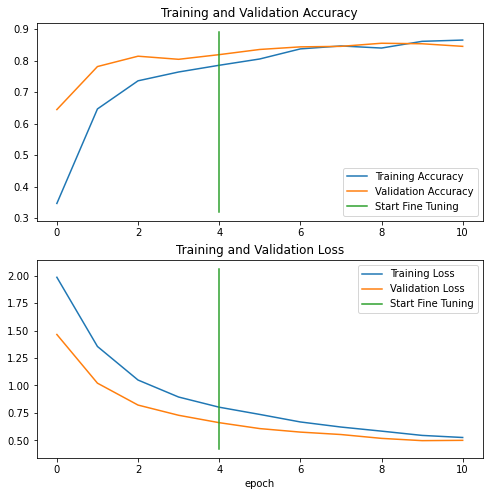

In [46]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

Pekala, tamam, ince ayardan sonra eğriler doğru yöne gidiyor gibi görünüyor. Ancak unutmayın, ince ayarın genellikle daha büyük miktarda veriyle en iyi sonucu verdiğine dikkat edilmelidir.

#### Model 4: Mevcut bir modelde tüm verilerin ince ayarını yapma

Bir modelin ince ayarının genellikle daha fazla veriyle nasıl çalıştığı hakkında yeterince konuşma, hadi deneyelim.

10 yemek sınıfı veri setimizin tam sürümünü indirerek başlayacağız.

In [47]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2021-06-20 18:50:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 2607:f8b0:400e:c09::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   266MB/s    in 1.9s    

2021-06-20 18:50:08 (266 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [48]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.

Şimdi görüntüleri tensör veri kümelerine çevireceğiz.

In [49]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Bu iyi görünüyor. Çalışmak için eğitim sınıflarında 10 kat daha fazla görselimiz var.

Test veri seti, önceki deneylerimiz için kullandığımızla aynıdır.

Şimdi olduğu gibi, model_2'miz verilerin yüzde 10'unda ince ayar yapıldı, bu nedenle tüm verilerde ince ayar yapmaya başlamak ve deneylerimizi tutarlı tutmak için 5 epoch'tan sonra kontrol ettiğimiz ağırlıklara geri döndürmemiz gerekiyor. 

Bunu göstermek için önce mevcut model_2'yi değerlendireceğiz.

In [50]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.5464 - accuracy: 0.8372


[0.5463631749153137, 0.8371999859809875]

Bunlar, result_fine_tune_10_percent ile aynı değerlerdir.

In [51]:
results_fine_tune_10_percent

[0.546363115310669, 0.8371999859809875]

Şimdi modeli kaydedilen ağırlıklara geri döndüreceğiz.

In [52]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path) # revert model back to saved weights

Ve sonuçlar, result_10_percent_data_aug ile aynı olmalıdır.

In [53]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 0.6856 - accuracy: 0.8156


[0.6855888962745667, 0.8155999779701233]

In [54]:
# Check to see if the above two results are the same (they should be)
results_10_percent_data_aug

[0.6855890154838562, 0.8155999779701233]

Pekala, önceki adımlar oldukça kafa karıştırıcı görünebilir ancak tek yaptığımız:

1. Verilerin %10'unda (tüm temel model katmanları donmuş halde) 5 epoch için bir özellik çıkarma transferi öğrenme modeli eğitildi ve ModelCheckpoint kullanılarak modelin ağırlıkları kaydedildi.
2. Temel modelin ilk 10 katmanı dondurulmamış olarak, 5 epoch daha için aynı %10'luk veri üzerinde aynı modelde ince ayar yapıldı.
3. Her seferinde sonuçları ve eğitim günlüklerini kaydetti.
4. 2 ile aynı adımları ancak tüm verilerle yapmak için modeli 1'den yeniden yükledi.

2 ile aynı adımlar?
> Evet, temel modelin son 10 katmanına tam veri seti ile 5 dönem daha ince ayar yapacağız ama önce kendimize hangi katmanların eğitilebilir olduğunu hatırlatalım.

In [55]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 False
3 global_average_pooling_layer True
4 output_layer True


Biraz daha spesifik olabilir miyiz?

In [58]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

İyi görünüyor! Son 10 katman eğitilebilir (dondurulmamış).

İnce ayara başlamadan önce yapmamız gereken bir adım daha var.

Ne olduğunu hatırlıyor musun?

Sana bir ipucu vereceğim. Ağırlıkları modelimize yeniden yükledik ve modellerimizde her değişiklik yaptığımızda ne yapmamız gerekiyor?

Onları yeniden derleyin!

Bu daha önce olduğu gibi olacak.

In [59]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Pekala, tüm verilerde ince ayar yapma zamanı!

In [60]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210620-190201
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 50s 193ms/step - loss: 0.8946 - accuracy: 0.7403 - val_loss: 0.6032 - val_accuracy: 0.8306
Epoch 6/10
235/235 [==============================] - 56s 235ms/step - loss: 0.8295 - accuracy: 0.7528 - val_loss: 0.5920 - val_accuracy: 0.8372
Epoch 7/10
235/235 [==============================] - 52s 219ms/step - loss: 0.7946 - accuracy: 0.7612 - val_loss: 0.5699 - val_accuracy: 0.8289
Epoch 8/10
235/235 [==============================] - 48s 204ms/step - loss: 0.7651 - accuracy: 0.7689 - val_loss: 0.5304 - val_accuracy: 0.8405
Epoch 9/10
235/235 [==============================] - 47s 197ms/step - loss: 0.7417 - accuracy: 0.7737 - val_loss: 0.4996 - val_accuracy: 0.8503
Epoch 10/10
235/235 [==============================] - 44s 186ms/step - loss: 0.7229 - accuracy: 0.7768 - val_loss: 0.4895 - val_accuracy: 0.8553


> 🔑 Not: Eğitim epoch başına daha uzun sürdü, ancak bu mantıklı çünkü öncekinden 10 kat daha fazla eğitim verisi kullanıyoruz.

Tüm test verilerini değerlendirelim.

In [61]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 9s 104ms/step - loss: 0.4842 - accuracy: 0.8588


[0.4842464327812195, 0.8587999939918518]

Güzel! Tüm verilerle yapılan ince ayar, modelimize hız kazandırmış gibi görünüyor, eğitim eğrileri nasıl görünüyor?

5
11
[0.3466666638851166, 0.6466666460037231, 0.7360000014305115, 0.7639999985694885, 0.7853333353996277, 0.7402666807174683, 0.7527999877929688, 0.7612000107765198, 0.7689333558082581, 0.7737333178520203, 0.7767999768257141]


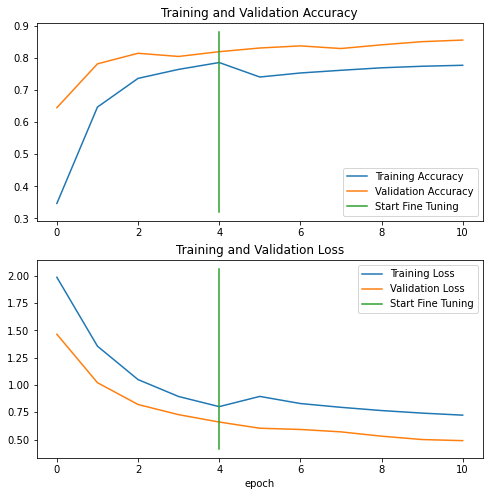

In [62]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

Görünüşe göre bu ekstra veriler yardımcı oldu! Bu kıvrımlar harika görünüyor. Ve daha uzun süre antrenman yaparsak, gelişmeye devam edebilirler.

## Deney verilerimizi TensorBoard'da görüntüleme

Şu anda deneysel sonuçlarımız defterimizin her yerine dağılmış durumda. Bunları birisiyle paylaşmak istersek, bir sürü farklı grafik ve metrik alacaklardır... eğlenceli bir zaman değil.

Ama tahmin et ne oldu?

Yardımcı fonksiyonumuz create_tensorflow_callback() ile yaptığımız TensorBoard geri çağrısı sayesinde modelleme deneylerimizi sürekli takip ediyoruz.

Bunları TensorBoard.dev'e yükleyip kontrol etmeye ne dersiniz?

Tensorboard dev upload komutu ile deneylerimizin kaydedildiği dizine iletebiliriz.

> 🔑 Not: TensorBoard.dev'e yüklediğiniz her şeyin herkese açık hale geleceğini unutmayın. Paylaşmak istemediğiniz antrenman kayıtları varsa yüklemeyin.

In [63]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished

2021-06-20 19:09:20.990864: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) y

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2

Sonuçları TensorBoard.dev'e yükledikten sonra, deneylerimizi görüntülemek ve karşılaştırmak ve gerekirse sonuçlarımızı başkalarıyla paylaşmak için kullanabileceğimiz paylaşılabilir bir bağlantı alırız.

> 🤔 Soru: Hangi model en iyi performansı gösterdi? Sizce bu neden? İnce ayar nasıl gitti?

Tensorboard dev list komutunu kullanarak önceki tüm TensorBoard.dev deneylerinizi bulmak için.

In [ ]:
# View previous experiments
!tensorboard dev list

Ve önceki bir denemeyi kaldırmak (ve genel görüntülemeden silmek) istiyorsanız şu komutu kullanabilirsiniz:

In [ ]:
# Remove previous experiments
# !tensorboard dev delete --experiment_id OUbW0O3pRqqQgAphVBxi8Q